# Clean light curves

The goals of this notebook are to: 

* Get light curves for analysis with STSP
 * read light curves from MAST
 * normalize each quarter of data by a 2nd order polynomial
* Measure the HAT-P-11 transit depth
 * identify transits that have the fewest/weakest starspot crossings
 * fit transit model to those most "spotless" transits
 * get a best depth measurement to use for STSP

### Open raw FITS files from MAST, clean out `nan`s

Save copies to `raw_long`, `raw_short` directories. 

In [1]:
%matplotlib inline
#%load_ext autoreload
#%autoreload 2

import os
from glob import glob
import datacleaner
reload(datacleaner)
from datacleaner import LightCurve
import numpy as np
import matplotlib.pyplot as plt

path_to_fits_files = '/local/tmp/kepler17/'

# Retrieve long and short cadence data
long_cadence_paths = glob(os.path.join(path_to_fits_files, '*llc.fits'))
short_cadence_paths = glob(os.path.join(path_to_fits_files, '*slc.fits'))

long_lc = LightCurve.from_raw_fits(long_cadence_paths, name='raw_long')
short_lc = LightCurve.from_raw_fits(short_cadence_paths, name='raw_short')

data_path = '/astro/users/bmmorris/git/hat-11/lightcurves'
#long_lc.save_to(data_path)
#short_lc.save_to(data_path)

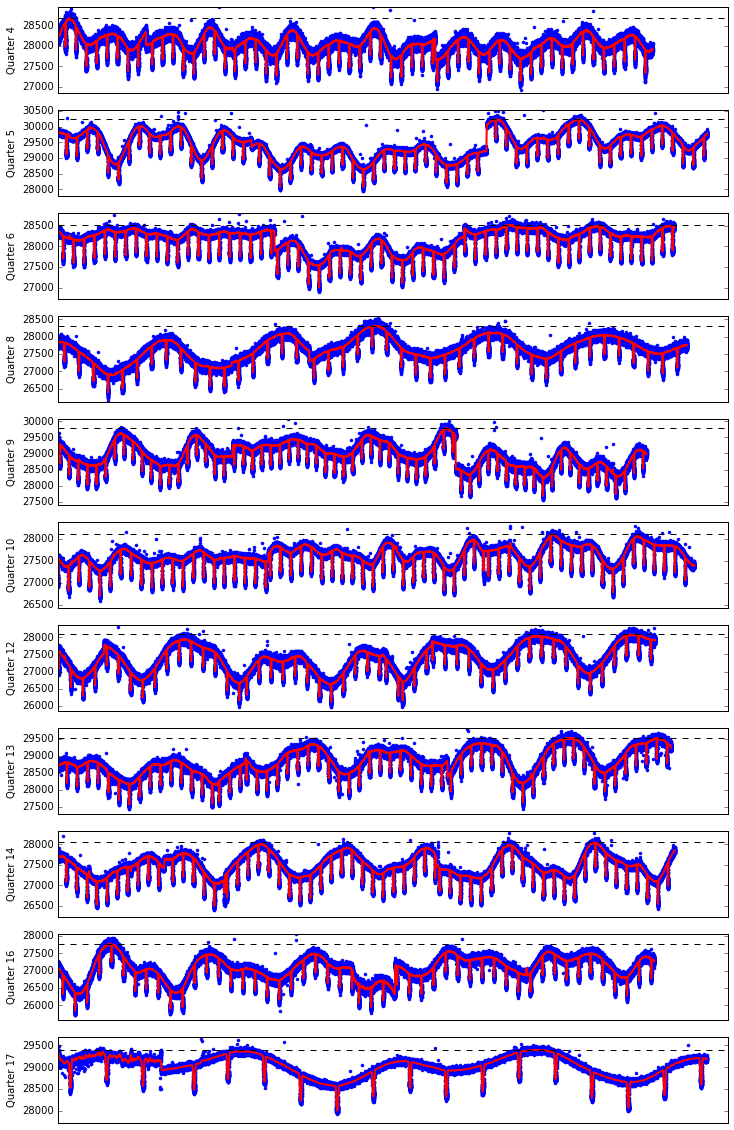

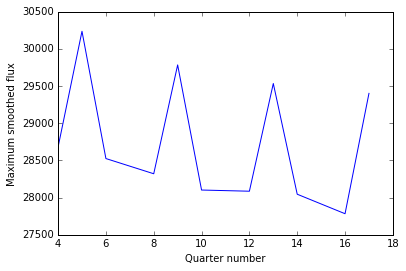

In [2]:
available_quarters = short_lc.get_available_quarters()
quarters = [short_lc.get_quarter(q) for q in short_lc.get_available_quarters()]

from scipy.ndimage import gaussian_filter

fig, ax = plt.subplots(11, 1, figsize=(12, 20))
quarterly_maxes = {}
set_upper_limit = 4e4
for i, quarter_number, lc in zip(range(len(available_quarters)), available_quarters, quarters):
    fluxes = lc.fluxes[lc.fluxes < set_upper_limit]
    smoothed_fluxes = gaussian_filter(fluxes, sigma=20)
    quarterly_maxes[quarter_number] = np.max(smoothed_fluxes)

    ax[i].plot(fluxes, '.')
    ax[i].plot(smoothed_fluxes, 'r', lw=2)
    ax[i].axhline(np.max(smoothed_fluxes), ls='--', color='k')
    ax[i].set(ylabel='Quarter {0}'.format(quarter_number), 
              ylim=[0.99*smoothed_fluxes.min(), 1.01*smoothed_fluxes.max()],
              xticks=[])
plt.show()
# plt.plot(fluxes, '.')
# plt.plot(smoothed_fluxes, 'r', lw=3)
# plt.xlim([4e4, 5.5e4])
plt.figure()
plt.plot(quarterly_maxes.keys(), quarterly_maxes.values())
plt.xlabel('Quarter number')
plt.ylabel('Maximum smoothed flux');

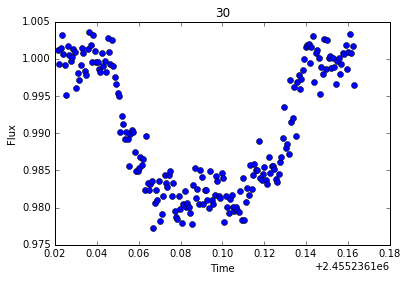

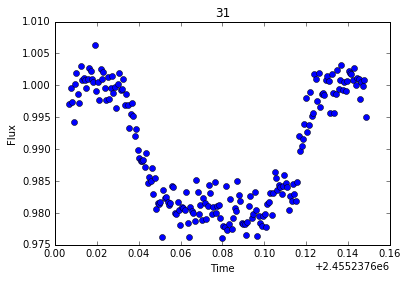

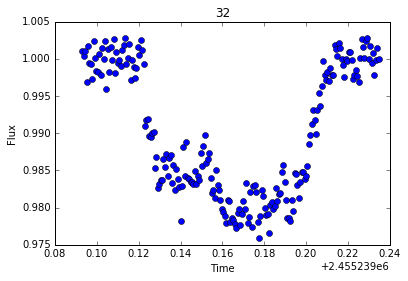

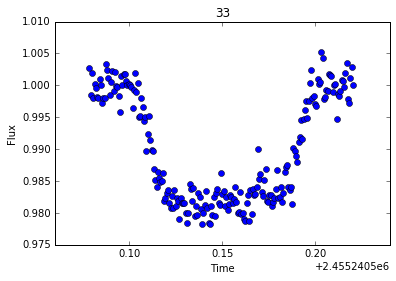

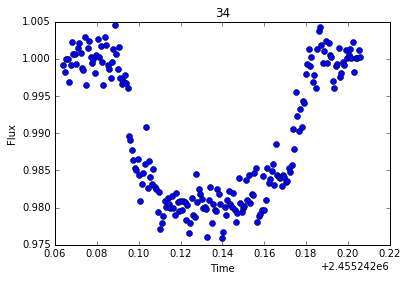

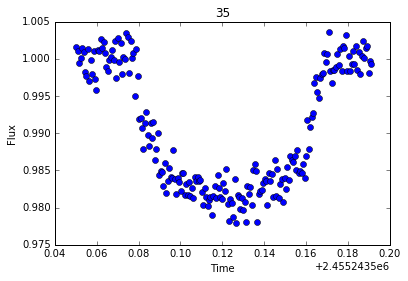

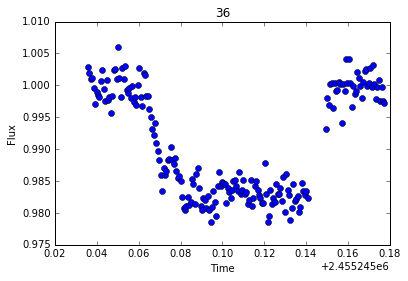

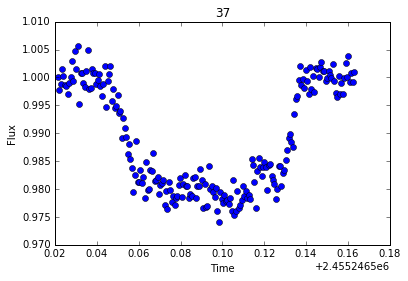

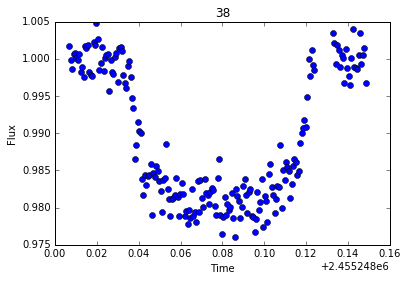

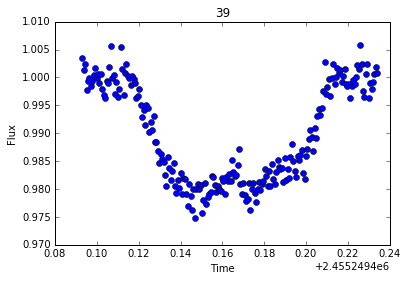

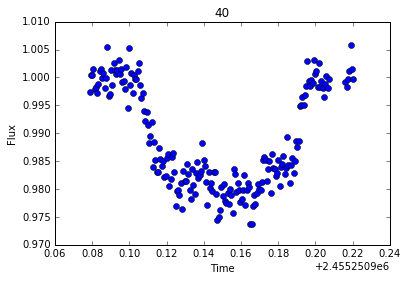

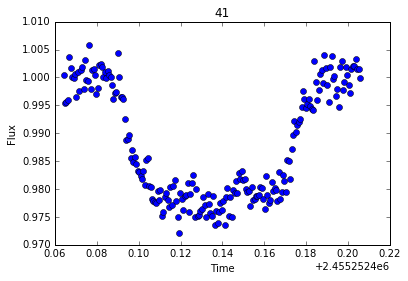

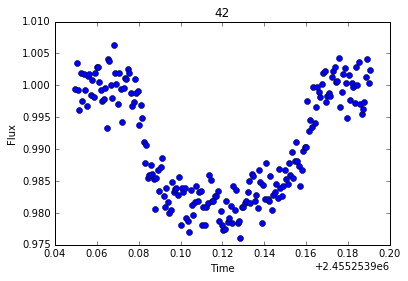

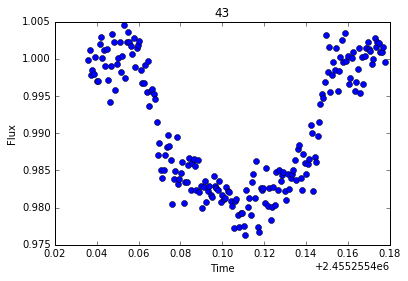

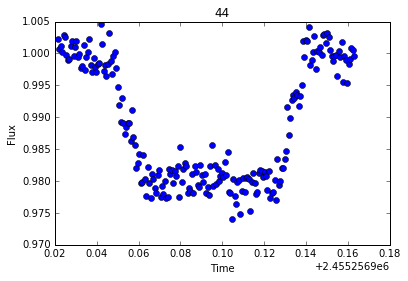

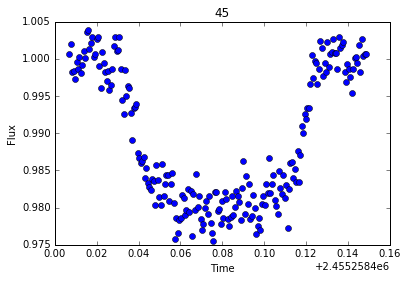

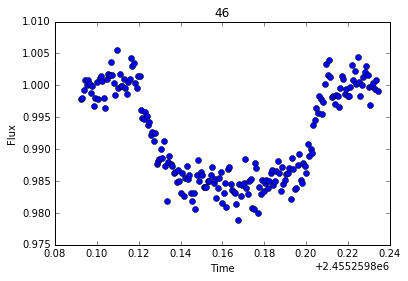

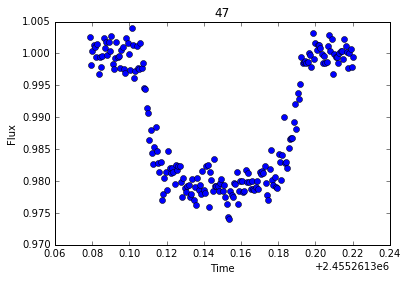

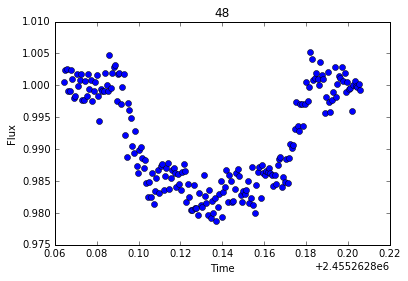

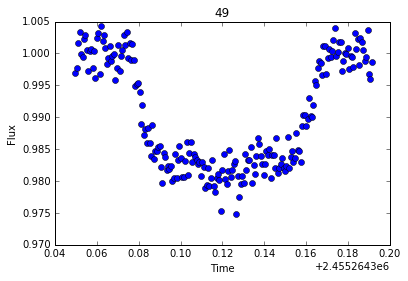

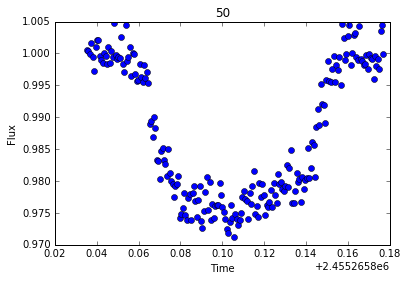

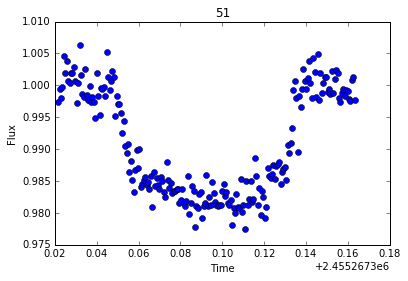

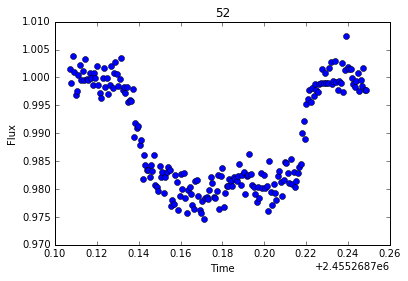

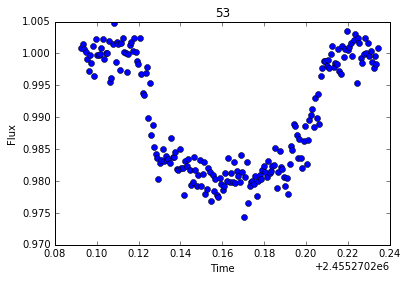

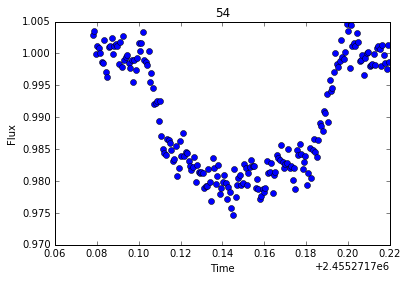

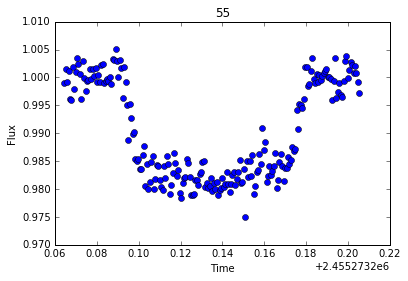

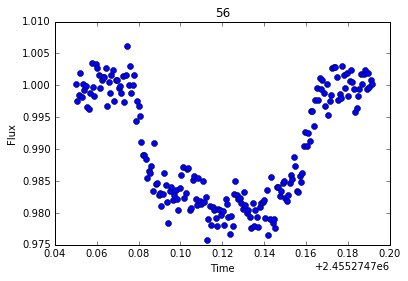

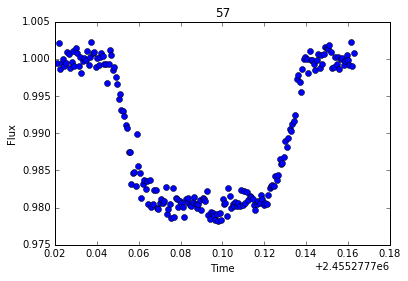

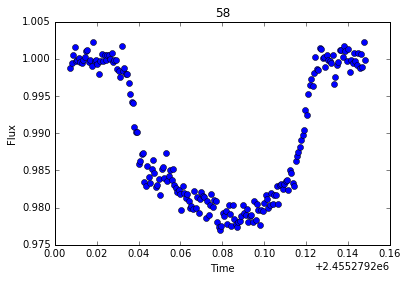

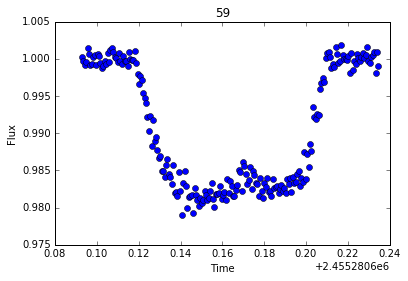

In [4]:
from datacleaner import kepler17_params_db
k17_params = kepler17_params_db()
short_cadence = LightCurve(name='transits_short', 
                           **short_lc.mask_out_of_transit(params=k17_params))
transits = short_cadence.get_transit_light_curves(params=k17_params)
# Remove data if there aren't enough fluxes
transits = [transit for transit in transits if len(transit.times) > 180]
    
for transit in transits: 
    transit.subtract_polynomial_baseline(order=2, params=k17_params)
    transit.fluxes += quarterly_maxes[transit.quarters[0]]
    transit.fluxes /= quarterly_maxes[transit.quarters[0]]
    transit.errors /= quarterly_maxes[transit.quarters[0]]

for i in range(30, 60):
    transits[i].plot(k17_params)

### Identify "spotless" transits

* do rough model fit to each transit with `scipy.optimize.fmin` including only a few transit parameters ($R_p/R_s$, $a/R_s$, $i$, $t_0$)
* Measure $\chi^2$ for best-fit model
 
**Hypothesis**: $\chi^2$ can be used as a proxy for inverse starspot-importance in each transit. Transits with low $\chi^2$ are well-described by a simple transit model, which implies they have few spot crossings. 

In [5]:
# Warning: this step fits each transit in the short cadence data and is slow (~2 min)
import os
chi2_file_path = 'chi2.npy'
if not os.path.exists(chi2_file_path):
    chi2 = np.array([transit.fiducial_transit_fit(k17_params)[1] for transit in transits])
    np.save(chi2_file_path, chi2)
else:
    chi2 = np.load(chi2_file_path)

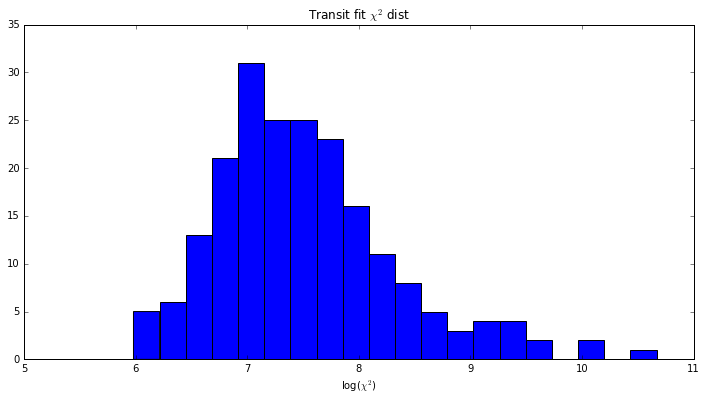

In [6]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 6))
ax.hist(np.log(chi2), 20)
ax.set(xlabel=r'log($\chi^2$)', title=r'Transit fit $\chi^2$ dist')
plt.show()

The distribution of $\chi^2$ shows that there's a long tail of poor fits to the data, and a handful of very good fits. The handful of very good fits all have $\log{\chi^2} < 6.5$. Any higher than 6.5 and there are readily visible spot-crossings in the transit. Now filter out only these transits with $\log{\chi^2} < 6.5$ for detailed transit analysis.

### Combine "spotless" light curves, fit model

In [7]:
chi2 = []
depths = []
for transit in transits:
    p, chi = transit.fiducial_transit_fit(k17_params)
    depths.append(p[0])
    chi2.append(chi)

datacleaner.py:123: RuntimeWarning: invalid value encountered in double_scalars
  rp = depth**0.5


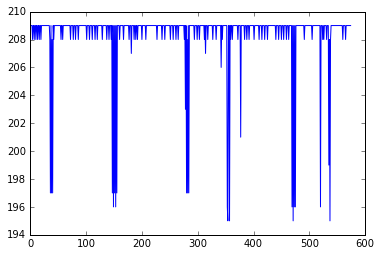

In [8]:
plt.plot([len(t.times) for t in transits])

# spotless transits: 14


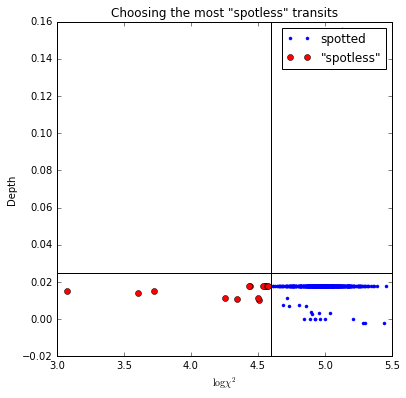

In [9]:
#chi2_threshold = 6.1
#depth_threshold = 0.003513

chi2_threshold = 4.6#2.45#3.45#6.7
depth_threshold = 0.025
reload(datacleaner)
from datacleaner import concatenate_transit_light_curves
spotless_transit_inds = (np.log(chi2) < chi2_threshold) * (np.array(depths) < depth_threshold)
spotless_transits = concatenate_transit_light_curves([transit for i, transit in enumerate(transits) 
                                                      if spotless_transit_inds[i]], name='spotless_transits')
spotless_transits.save_to(data_path, overwrite=True)

print('# spotless transits: {}'.format(np.count_nonzero(spotless_transit_inds)))
fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(np.log(chi2), depths, '.', label='spotted')
ax.plot(np.log(chi2)[spotless_transit_inds], 
        np.array(depths)[spotless_transit_inds], 'ro', label='"spotless"')

ax.axvline(chi2_threshold, color='k')
ax.axhline(depth_threshold, color='k')
ax.legend(loc='upper right')
#ax.set_ylim([0.00335, 0.00355])
ax.set(xlabel=r'$\log{\chi^2}$', ylabel=r'Depth', 
       title='Choosing the most "spotless" transits');

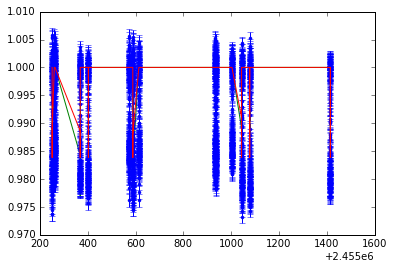

In [10]:
leastsq_fit_params, chi2_spotless = spotless_transits.fiducial_transit_fit(k17_params, plots=True)

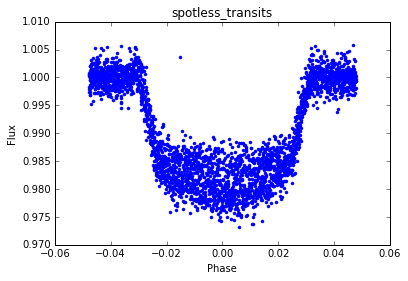

In [11]:
spotless_transits.plot(k17_params, phase=True, plot_kwargs={'marker':'.', 'lw':0})

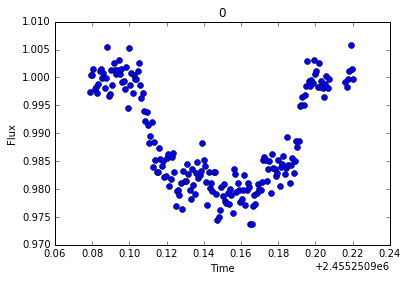

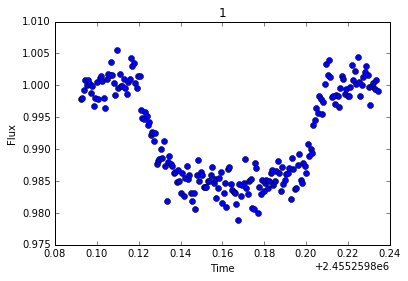

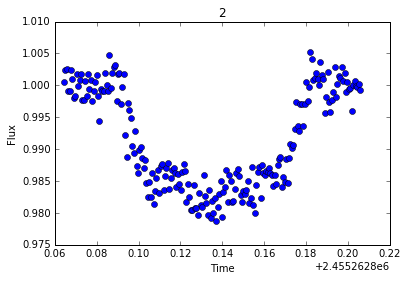

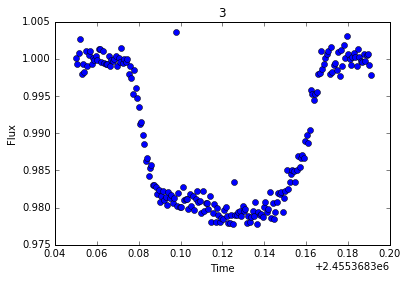

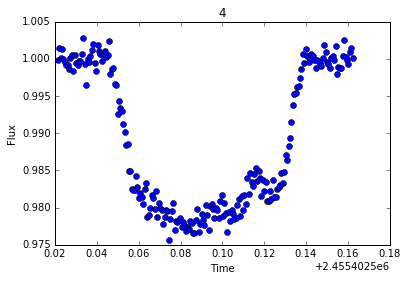

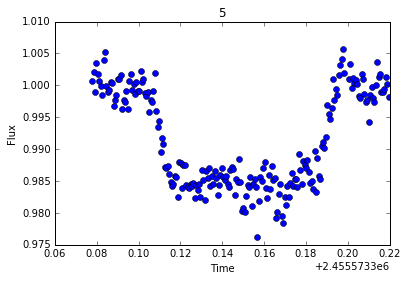

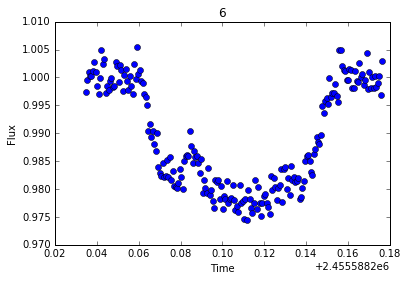

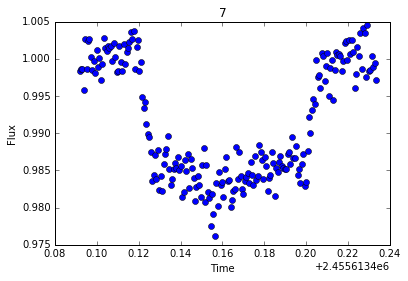

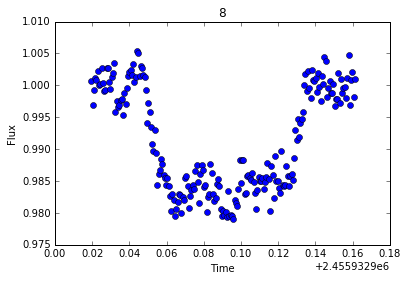

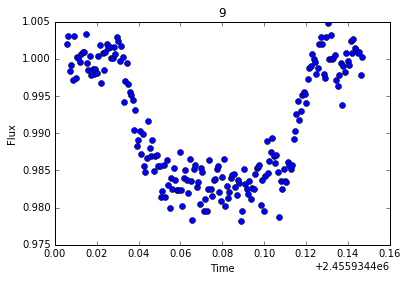

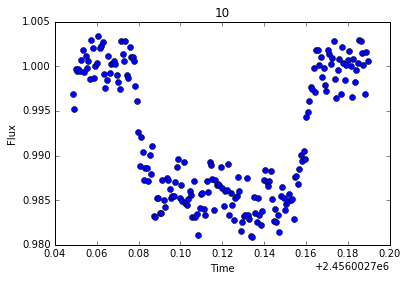

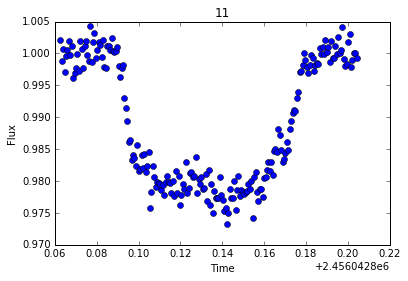

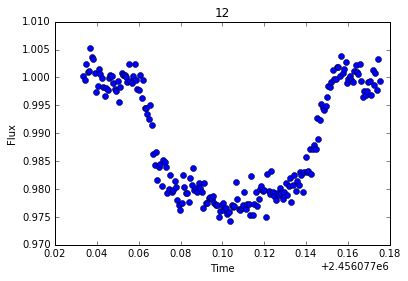

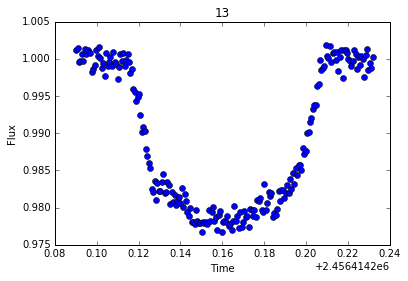

In [13]:
each_spotless_transit = spotless_transits.get_transit_light_curves(k17_params)

for sptlstr in each_spotless_transit:
    sptlstr.plot(k17_params)

In [ ]:
print("Mean times of three 'spotless' transits: {0}"
      .format([t.times.jd.mean() for t in each_spotless_transit]))

### Use `emcee` to get PDFs for interesting transit parameters

Here I'm fitting for: $t_0$, depth, duration, impact parameter and Kipping's efficient two-parameter limb-darkening terms $q_1$, $q_2$.

In [ ]:
import cleanfit
reload(cleanfit)
from cleanfit import run_emcee, plot_triangle

# Use least-sq results and Deming 2011 params to start MCMC
[t0, depth, dur, b] = [2454605.89155, 0.003365, 0.092, 0.307]#leastsq_fit_params
[q1, q2] = [0.518, 0.426] # Claret -> Kipping
p0 = [t0, depth, dur, b, q1, q2]
n_steps = 1500
scale_the_errors_by_a_factor_of = 1.0
transit_lc = spotless_transits
# n_steps=1000 Takes about ~3 min
samples, sampler = run_emcee(p0, transit_lc.times.jd, transit_lc.fluxes, 
                             scale_the_errors_by_a_factor_of*transit_lc.errors, 
                             n_steps)

In [ ]:
reload(cleanfit)
from cleanfit import run_emcee, plot_triangle
print("accept frac = {}".format(np.mean(sampler.acceptance_fraction)))
plot_triangle(samples[:, :])

In [ ]:
import cleanfit
reload(cleanfit)
from cleanfit import print_emcee_results
from IPython.display import display_latex, Latex

#print_emcee_results(samples)
Latex(print_emcee_results(samples))

### Fit for ephemeris using best-fit parameters from "spotless" fits

In [ ]:
import cleanfit
reload(cleanfit)
from cleanfit import run_emcee_ephemeris, plot_triangle

# Use least-sq results and Deming 2011 params to start MCMC
depth, dur, b, q1, q2 = np.median(samples[:, 1:], axis=0)

p0 = [np.median(samples[:, 0]), 4.8878018]
bestfit_transit_params = [depth, dur, b, q1, q2]

scale_the_errors_by_a_factor_of = 1.0
# normalized_short_transits = concatenate_transit_light_curves(transits, 
#                                                              name='normalized short cadence transits')

low_chi2 = (np.log(chi2) < chi2_threshold)
low_chi2_transits = [transit for i, transit in enumerate(transits) 
                     if low_chi2[i]]
low_chi2_transits_all = concatenate_transit_light_curves(low_chi2_transits, name='low_chi2_transits')
low_chi2_transits_two = concatenate_transit_light_curves([low_chi2_transits[0], 
                                                          low_chi2_transits[-1]])

n_steps = 1800
sample_factor = 1
samples_eph, sampler_eph = run_emcee_ephemeris(p0, low_chi2_transits_two.times.jd[::sample_factor], 
                                               low_chi2_transits_two.fluxes[::sample_factor], 
                                               low_chi2_transits_two.errors[::sample_factor], 
                                               n_steps, bestfit_transit_params, 
                                               n_walkers=20)

In [ ]:
plot_triangle(samples_eph)

In [ ]:
for i, p in enumerate(['mid-transit time', 'period']):
    mid, minus, plus = np.percentile(samples_eph[:,i], [50, 16, 84])
    print("{3}: {0:.8f} +{1:.8f} -{2:.8f}".format(mid, plus-mid, mid-minus, p))

Now with new period measurement, fit the spotless transits again. These are the final posteriors.

In [ ]:
import cleanfit
reload(cleanfit)
from cleanfit import run_emcee, plot_triangle

p0 = np.median(samples[:, :], axis=0) # [t0, depth, dur, b, q1, q2]
n_steps = 2000
scale_the_errors_by_a_factor_of = 1.0
transit_lc = spotless_transits
# n_steps=1000 Takes about ~3 min
samples_refined, sampler_refined = run_emcee(p0, transit_lc.times.jd, transit_lc.fluxes, 
                                             scale_the_errors_by_a_factor_of*transit_lc.errors, 
                                             n_steps, P = np.percentile(samples_eph[:,1], 50),
                                             n_walkers=70)

In [ ]:
print("accept frac = {}".format(np.mean(sampler_refined.acceptance_fraction)))
plot_triangle(samples_refined[:, :])

In [ ]:
Latex(print_emcee_results(samples_refined))

In [ ]:
period_mid, period_minus, period_plus = np.percentile(samples_eph[:,1], [50, 16, 84])
period_upper = period_plus-period_mid
period_lower = period_plus-period_mid
best_fit_period = mid
Latex("$P: {{{0:.8f}}}^{{+{1:.8f}}}_{{-{2:.8f}}}$"
      .format(period_mid, period_plus-period_mid, period_mid-period_minus))

Create LaTeX table for paper

In [ ]:
mid, minus, plus = np.percentile(samples_refined, [50, 16, 84], axis=0)
lower = mid - minus
upper = plus - mid

best_parameter_dict = {'t0': (mid[0], lower[0], upper[0]), 
                       'depth': (mid[1], lower[1], upper[1]), 
                       'duration': (mid[2], lower[2], upper[2]), 
                       'b': (mid[3], lower[3], upper[3]), 
                       'q1': (mid[4], lower[4], upper[4]), 
                       'q2': (mid[5], lower[5], upper[5]), 
                       'P': (period_mid, period_lower, period_upper)}

table_lines = ['$P$ [days] & ${{{0:.7f}}}^{{-{1:.7f}}}_{{+{2:.7f}}}$ \\\\',
                '$T_0$  [BJD] &  ${{{0}}}_{{-{1:0.6f}}}^{{+{2:0.6f}}}$ \\\\',
                '$T_{{14}}$ [days] &  ${{{0:.04f}}}_{{-{1:.04f}}}^{{+{2:.04f}}}$ \\\\',
                '$(R_p / R_s)^2$  &  ${{{0:.5f}}}_{{-{1:.5f}}}^{{+{2:.5f}}}$ \\\\',
                '$b$  &  ${{{0:.03f}}}_{{-{1:.03f}}}^{{+{2:.03f}}} $ \\\\',
                '$q_1$  & ${{{0:.2f}}}_{{-{1:.2f}}}^{{+{2:.2f}}}$ \\\\',
                '$q_2$  &  ${{{0:.2f}}}_{{-{1:.2f}}}^{{+{2:.2f}}}$ \\\\']
table_lines_order = ['P', 't0', 'duration', 'depth', 'b', 'q1', 'q2']
table_contents = ""

for line, param_i in zip(table_lines, table_lines_order):
    table_contents += line.format(*best_parameter_dict[param_i]) + '\n'

dropbox_path = '/astro/users/bmmorris/Dropbox/sharelatex/STSP_HAT-P-11/'
with open(os.path.join(dropbox_path, 'results', 'hat-11_light_curve_params.txt'), 'w') as param_table:
    param_table.write(table_contents)

In [ ]:
from datacleaner import T14b2aRsi, params

ecosw = 0.261# ? 0.082
esinw = 0.085# ? 0.043
eccentricity = np.sqrt(ecosw**2 + esinw**2)
omega = np.degrees(np.arccos(ecosw/eccentricity))
print(omega)

depth_refined, dur_refined, b_refined = np.median(samples_refined[:, [1, 2,3]], axis=0)
a_over_Rs, inclination = T14b2aRsi(best_fit_period, dur_refined, 
                                   b_refined, depth_refined**0.5, eccentricity, omega)
print("Inclination: {0}".format(inclination))

def rho_star(samples, P=best_fit_period):
    import astropy.units as u
    from astropy.constants import G
    """Calculate stellar density from MCMC chain samples"""
    T14 = samples[:,2]
    b = samples[:,3]
    aRs, i_deg = T14b2aRsi(P, T14, b, depth_refined**0.5, eccentricity, omega)
    print(np.percentile(aRs, 50), np.percentile(i_deg, 50))
    rho_s = 3*np.pi/(G*(P*u.day)**2) * aRs**3
    rho_s = rho_s.to(u.g/u.cm**3)
    
    mid, minus, plus = np.percentile(rho_s, [50, 16, 84])
    lower = mid - minus
    upper = plus - mid
    
    return mid, lower, upper

rho = rho_star(samples_refined)
print("Mean stellar density: {0:.2f} +{1:.2f} -{2:.2f} g cm^-3".format(*rho))

from astropy.constants import M_sun, R_sun
import astropy.units as u
print("Mean stellar density: {0:.6f} rho_sun".format((rho[0]*u.g/u.cm**3).to(M_sun/(4./3*np.pi*R_sun**3)).value))

print("Note, this is larger than the asteroseismic result "
      "from Christensen-Dalsgaard+2010 of 2.5127 g/cm^3")
dropbox_path = '/astro/users/bmmorris/Dropbox/sharelatex/STSP_HAT-P-11/'
with open(os.path.join(dropbox_path, "results", "stellar_density.txt"), 'w') as density_out:
    density_out.write("{0:.2f}^{{+{1:.2f}}}_{{-{2:.2f}}}".format(*rho))
    

In [ ]:
omega = np.degrees(np.arccos(ecosw/eccentricity))

In [ ]:
ars, _ = T14b2aRsi(best_fit_period, samples_refined[:,2], samples_refined[:,3], 
          depth_refined**0.5, eccentricity, omega)
print(np.median(ars), a_over_Rs)

In [ ]:
#(best_fit_period, np.percentile(samples_refined[:,2], 50), np.percentile(samples_refined[:,3], 50), 
#depth_refined**0.5, params.ecc, params.w)

check_b = np.percentile(samples_refined[:,3], 50)
check_duration = (best_fit_period/np.pi * np.arcsin(np.sqrt((1 + depth_refined**0.5)**2 - check_b**2)/
                                                   (a_over_Rs*np.sin(np.radians(inclination)))) * 
                  np.sqrt(1-eccentricity**2)/(1 + eccentricity*np.sin(np.radians(omega))))
print(check_duration, check_b, inclination, a_over_Rs)

print(check_b == a_over_Rs*np.cos(np.radians(inclination)) * 
      (1-eccentricity**2)/(1 + eccentricity*np.sin(np.radians(omega))))
#print((1-eccentricity**2)/(1 + eccentricity*np.sin(np.radians(omega))))

In [ ]:
best_fit_results = np.median(samples_refined, axis=0)
from cleanfit import generate_model_lc_short

dtimes = np.diff(transit_lc.times.jd)
#t_splits = np.argwhere(dtimes > 10*np.median(dtimes)).T[0] + 1
t_splits = np.argwhere(dtimes > 1000*np.median(dtimes)).T[0] + 1
t_splits = np.concatenate([[0], t_splits, [len(dtimes)]])

fig, ax = plt.subplots(2, len(t_splits)-1, figsize=(16, 10), sharex='col', sharey='row')

for i in range(len(t_splits) - 1):
    start, stop = t_splits[i], t_splits[i+1]

    mean_jd_int = int(np.mean(transit_lc.times.jd[start:stop]))
    
    t_min = transit_lc.times.jd[start:stop].min()
    t_max = transit_lc.times.jd[start:stop].max()
    model_times = np.linspace(t_min, t_max, 3000)
    transitmodel_fine = generate_model_lc_short(model_times, 
                                           *best_fit_results, 
                                           P=np.median(samples_eph[:, 1]))

    transitmodel = generate_model_lc_short(transit_lc.times.jd[start:stop], 
                                           *best_fit_results, 
                                           P=np.median(samples_eph[:, 1]))
    
    ax[0, i].plot(transit_lc.times.jd[start:stop] - mean_jd_int, 
                  transit_lc.fluxes[start:stop], 'ko')

    ax[0, i].plot(model_times - mean_jd_int, transitmodel_fine,
                  'r', lw=2)

    ax[1, i].errorbar(transit_lc.times.jd[start:stop] - mean_jd_int, 
                      transit_lc.fluxes[start:stop] - transitmodel, 
                      transit_lc.errors[start:stop],
                      fmt='.', color='k', ecolor='gray')
    
    ax[1, i].axhline(0, ls='--', color='k')
    ax[1, i].set_xlabel("JD - {0}".format(mean_jd_int))

    transit_chi2 = (np.sum((transit_lc.fluxes[start:stop] - transitmodel)**2 / 
                           transit_lc.errors[start:stop]**2) /
                    (len(transit_lc.fluxes[start:stop]) - len(best_fit_results)))
    ax[0, i].set_title("$\chi^2 = {0:.2f}$".format(transit_chi2))
    
    ax[0, i].set_xlim([transit_lc.times.jd[start:stop].min() - mean_jd_int - 0.005, 
                       transit_lc.times.jd[start:stop].max() - mean_jd_int + 0.005])
    
ax[0, 0].set_ylabel('Flux')
ax[1, 0].set_ylabel('Residuals')
spacing = 0.05
fig.subplots_adjust(hspace=spacing, wspace=spacing)
fig.suptitle('"Spotless" transits', fontsize=20, ha='center')
fig.savefig("../plots/splotless_transits.png", bbox_inches='tight')
plt.show()

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(8, 12), sharex='col', sharey='row')

def jd_to_phase(jd_array):
    phase = ((jd_array - best_fit_results[0]) % 
             np.median(samples_eph[:, 1])) / np.median(samples_eph[:, 1])
    phase[phase > 0.5] -= 1
    return phase

plt.rc('font', size=13)
transit_chi2 = []
n_fluxes = []
for i in range(len(t_splits) - 1):
    start, stop = t_splits[i], t_splits[i+1]

    #mean_jd_int = int(np.mean(transit_lc.times.jd[start:stop]))
    
    t_min = transit_lc.times.jd[start:stop].min()
    t_max = transit_lc.times.jd[start:stop].max()
    model_times = np.linspace(t_min, t_max, 3000)
    model_phase = jd_to_phase(model_times)
    transitmodel_fine = generate_model_lc_short(model_times, 
                                           *best_fit_results, 
                                           P=np.median(samples_eph[:, 1]))

    transitmodel = generate_model_lc_short(transit_lc.times.jd[start:stop], 
                                           *best_fit_results, 
                                           P=np.median(samples_eph[:, 1]))
    
    phase = jd_to_phase(transit_lc.times.jd[start:stop])
    
    offset_factor = 0.002*i
    ax[0].plot(phase,  transit_lc.fluxes[start:stop] + offset_factor, 'ko')

    ax[0].plot(model_phase, transitmodel_fine + offset_factor, 'r', lw=2)

    ax[1].errorbar(phase, 
                  transit_lc.fluxes[start:stop] - transitmodel, 
                  transit_lc.errors[start:stop],
                  fmt=',', color='gray', capsize=0, ecolor='gray', alpha=0.7)
    
    ax[1].plot(phase, transit_lc.fluxes[start:stop] - transitmodel, 
              '.', color='k')
    
    transit_chi2.append(np.sum((transit_lc.fluxes[start:stop] - transitmodel)**2 / 
                           transit_lc.errors[start:stop]**2))
    n_fluxes.append(len(transit_lc.fluxes[start:stop]))
total_chi2 = np.sum(transit_chi2)/(np.sum(n_fluxes) - 6)
print("overall reduced chi2 = {0}".format(total_chi2))

ax[1].set_xlabel('Orbital Phase')    
ax[1].axhline(0, ls='-', color='r', lw=2)
ax[0].set_ylabel('Flux')
ax[1].set_ylabel('Residuals')

# Set tick labels
ax[1].set_yticks(np.arange(-0.0006, 0.0008, 0.0002))
ax[0].set_yticks(np.arange(0.996, 1.005, 0.002))

spacing = 0.05
fig.subplots_adjust(hspace=0)
#fig.subplots_adjust(hspace=spacing, wspace=spacing)
#fig.suptitle('"Spotless" transits', fontsize=20, ha='center')
dropbox_path = '/astro/users/bmmorris/Dropbox/sharelatex/STSP_HAT-P-11/'

fig.savefig(os.path.join(dropbox_path, "figures", "splotless_transits_compact.png"), 
            bbox_inches='tight', dpi=500)
plt.show()

In [ ]:
long_cadence = LightCurve.from_dir('../lightcurves/normalized_long')

fig, ax = plt.subplots(1, 3, figsize=(16, 7))
for i in range(len(t_splits) - 1):
    start, stop = t_splits[i], t_splits[i+1]
    mean_jd = np.mean(transit_lc.times.jd[start:stop])
    
    in_broad_window = np.abs(long_cadence.times.jd - mean_jd) < 15
    in_narrow_window = np.abs(long_cadence.times.jd - mean_jd) < 0.1
    
    ax[i].plot(long_cadence.times.jd[in_broad_window], 
               long_cadence.fluxes[in_broad_window], 'ko')
    ax[i].plot(long_cadence.times.jd[in_narrow_window], 
               long_cadence.fluxes[in_narrow_window], 'ro')

plt.show()

### Converting Kipping 2 limb darkening parameters into four-parameter law

$$ \text{Quadratic: } I(\mu)/I(1) = 1−a(1−\mu)−b(1−\mu)^2$$

$$ \text{"Nonlinear": } I(\mu)/I(1) = 1−a(1−\mu^{1/2})−b(1−\mu)-c(1-\mu^{3/2}) - d(1-\mu^2)$$

We can't convert directly from Quadratic to nonlinear, but here I'll try fitting a nonlinear model to our quadratic solution. 

In [ ]:
mu = np.linspace(0, 1, 1000)

def quadratic_law(p, mu):
    u1, u2 = p
    return 1 - u1*(1-mu) - u2*(1-mu)**2

def nonlinear_law(p, mu):
    a, b, c, d = p
    return 1 - a*(1-mu**0.5) - b*(1-mu) - c*(1-mu**1.5) - d*(1-mu**2)

def kipping_to_quadratic(p):
    q1, q2 = p
    u1 = 2*np.sqrt(q1)*q2
    u2 = np.sqrt(q1)*(1 - 2*q2)
    return u1, u2

best_fit_quadratic = kipping_to_quadratic(np.median(samples_refined[:, -2:], axis=0))
best_quadratic_model = quadratic_law(best_fit_quadratic, mu)

from scipy import optimize

initp = [0, 0.6, 0, 0]
bestp = optimize.leastsq(lambda p, mu: best_quadratic_model - nonlinear_law(p, mu), 
                         initp, args=(mu))[0]
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
ax[0].plot(mu, best_quadratic_model, color='k', label='Quadratic')
ax[0].plot(mu, nonlinear_law(bestp, mu), ls='--', color='r', label='Nonlinear')
ax[1].plot(mu, nonlinear_law(bestp, mu) - best_quadratic_model)

ax[0].legend()
ax[0].set(xlabel=r'$\mu$', ylabel=r'$I(\mu)/I(1)$')
ax[1].set(xlabel=r'$\mu$', ylabel='Residuals')

ax[0].text(0.05, 0.9, 
           'a, b, c, d = \n{0:.3f}, {1:.3f}, {2:.3f}, {3:.3f}'
           .format(*bestp), fontsize=16)
print("Best nonlinear limb-darkening parameters: \n"
      "a, b, c, d = \n{0:.5f}, {1:.5f}, {2:.5f}, {3:.5f}"
           .format(*bestp))
plt.show()

In [ ]:
best_fit_quadratic

In [ ]:
u1, u2 = best_fit_quadratic

def quadratic_to_nonlinear(u1, u2):
    a1 = a3 = 0
    a2 = u1 + 2*u2
    a4 = -u2
    return (a1, a2, a3, a4)

best_fit_nonlinear = quadratic_to_nonlinear(*best_fit_quadratic)
print("Non-linear parameters (algebraic trans): {0}".format(best_fit_nonlinear))

In [ ]:
ct = np.concatenate([t.times.jd for t in each_spotless_transit])
cf = np.concatenate([t.fluxes for t in each_spotless_transit])
ce = np.concatenate([t.errors for t in each_spotless_transit])

from astropy.io import ascii
from astropy.table import Table

tbl = Table([ct, cf, ce])
ascii.write(tbl, 'spotless.txt')

In [ ]:
print(np.std(short_lc.fluxes[:500]))

from statsmodels.robust.scale import mad
print(mad(short_lc.fluxes[:500]))
plt.plot(short_lc.fluxes[:500])